# IR Lab Tutorial (Research Oriented): Classification of Medical Queries and Documents



In [ ]:
# This is only needed in Google Colab, in the dev container, everything should be installed already
!pip3 install tira trectools python-terrier

In [19]:
from tira.third_party_integrations import ensure_pyterrier_is_loaded
from tira.rest_api_client import Client
import pandas as pd

import pyterrier as pt
import matplotlib.pyplot as plt

ensure_pyterrier_is_loaded()
tira = Client()

# ClueWeb09 Web Track Results

Over all web tracks, 16 queries are health related and 184 are not health-related.

Purely lexical models (Dirichlet and BM25) models seem to perform better than semantic neural models on health related topics compared to not health-related topics.

In [4]:
clueweb_dataset_ids = [
    "irds:clueweb09/en/trec-web-2009",
    "irds:clueweb09/en/trec-web-2010",
    "irds:clueweb09/en/trec-web-2011",
    "irds:clueweb09/en/trec-web-2012",
]
all_datasets = [pt.get_dataset(dataset) for dataset in clueweb_dataset_ids]
all_topics = [dataset.get_topics(variant='query') for dataset in all_datasets]
all_query_health_classifications = [tira.pt.transform_queries('ir-benchmarks/fschlatt/query-health-classification', dataset) for dataset in all_datasets]

In [5]:
# all topics with mean health score > 150 are health-related
tira.pt.transform_queries('ir-benchmarks/fschlatt/query-health-classification', all_datasets[0])
pd.concat(
    [query_health_classification(topics) for query_health_classification, topics in zip(all_query_health_classifications, all_topics)]
).sort_values("mean_health_score", ascending=False).head(50)

,qid,query,mean_health_score,median_health_score,mean_medical_score,median_medical_score
45,196,sore throat,411.7695,411.7695,99.3674,99.3674
37,88,forearm pain,354.0813,354.0813,310.8832,310.8832
31,82,joints,331.5549,331.5549,240.9360,240.9360
27,128,atypical squamous cells,272.0022,277.4749,452.8779,399.4028
16,67,vldl levels,267.6323,267.6323,434.0579,434.0579
22,173,hip fractures,233.0622,233.0622,308.1734,308.1734
3,4,toilet,226.5945,226.5945,24.5363,24.5363
27,78,dieting,220.2939,220.2939,245.9618,245.9618
38,89,ocd,218.6667,218.6667,328.5885,328.5885
29,30,diabetes education,203.9913,203.9913,243.6227,243.6227


In [8]:
approaches = {
    "BM25": "ir-benchmarks/tira-ir-starter/BM25 Re-Rank (tira-ir-starter-pyterrier)",
    "Dirichlet": "ir-benchmarks/tira-ir-starter/DirichletLM Re-Rank (tira-ir-starter-pyterrier)",
    "MonoT5 Base": "ir-benchmarks/tira-ir-starter/MonoT5 Base (tira-ir-starter-gygaggle)",
    "Splade": "workshop-on-open-web-search/naverlabseurope/Splade (re-ranker)",
}

In [9]:
non_health_results = []
health_results = []
iterator = zip(all_topics, all_datasets, all_query_health_classifications)
for topics, dataset, query_health_classification in iterator:
    topics = query_health_classification(topics)
    qrels = dataset.get_qrels(variant="relevance")
    non_health_topics = topics.loc[topics["mean_health_score"] <= 150]
    health_topics = topics.loc[topics["mean_health_score"] >= 150]
    rankings = [
        tira.pt.from_submission(approach, dataset) for approach in approaches.values()
    ]
    non_health_results.append(
        pt.Experiment(
            rankings,
            non_health_topics,
            qrels,
            ['ndcg_cut.10', 'recip_rank'],
            names=list(approaches.keys()),
            perquery=True
        )
    )
    health_results.append(
        pt.Experiment(
            rankings,
            health_topics,
            qrels,
            ['ndcg_cut.10', 'recip_rank'],
            names=list(approaches.keys()),
            perquery=True
        )
    )

There are multiple qrel fields available: ['relevance', 'method', 'iprob']. Defaulting to "relevance", but to use a different one, supply variant


Download: 842kiB [00:00, 8.80MiB/s]


Download finished. Extract...
Extraction finished:  /root/.tira/extracted_runs/ir-benchmarks/clueweb09-en-trec-web-2009-20230107-training/tira-ir-starter


Download: 57.4MiB [00:00, 94.9MiB/s]


Download finished. Extract...
Extraction finished:  /root/.tira/extracted_runs/workshop-on-open-web-search/clueweb09-en-trec-web-2009-20230107-training/naverlabseurope


[INFO] [starting] https://trec.nist.gov/data/web/10/10.adhoc-qrels.final
[INFO] [finished] https://trec.nist.gov/data/web/10/10.adhoc-qrels.final: [00:00] [837kB] [2.05MB/s]
Download: 842kiB [00:00, 6.95MiB/s]                                               


Download finished. Extract...
Extraction finished:  /root/.tira/extracted_runs/ir-benchmarks/clueweb09-en-trec-web-2010-20230107-training/tira-ir-starter


Download: 844kiB [00:00, 7.41MiB/s]


Download finished. Extract...
Extraction finished:  /root/.tira/extracted_runs/ir-benchmarks/clueweb09-en-trec-web-2010-20230107-training/tira-ir-starter


Download: 855kiB [00:00, 7.66MiB/s]


Download finished. Extract...
Extraction finished:  /root/.tira/extracted_runs/ir-benchmarks/clueweb09-en-trec-web-2010-20230107-training/tira-ir-starter


Download: 59.8MiB [00:00, 109MiB/s] 


Download finished. Extract...
Extraction finished:  /root/.tira/extracted_runs/workshop-on-open-web-search/clueweb09-en-trec-web-2010-20230107-training/naverlabseurope


/usr/local/lib/python3.10/dist-packages/pyterrier/pipelines.py:129: UserWarning: 2 topic(s) not found in qrels. Scores for these topics are given as NaN and should not contribute to averages.
  warn(f'{backfill_count} topic(s) not found in qrels. Scores for these topics are given as NaN and should not contribute to averages.')
/usr/local/lib/python3.10/dist-packages/pyterrier/pipelines.py:129: UserWarning: 2 topic(s) not found in qrels. Scores for these topics are given as NaN and should not contribute to averages.
  warn(f'{backfill_count} topic(s) not found in qrels. Scores for these topics are given as NaN and should not contribute to averages.')
/usr/local/lib/python3.10/dist-packages/pyterrier/pipelines.py:129: UserWarning: 2 topic(s) not found in qrels. Scores for these topics are given as NaN and should not contribute to averages.
  warn(f'{backfill_count} topic(s) not found in qrels. Scores for these topics are given as NaN and should not contribute to averages.')
/usr/local/li

Download finished. Extract...
Extraction finished:  /root/.tira/extracted_runs/ir-benchmarks/clueweb09-en-trec-web-2011-20230107-training/tira-ir-starter


Download: 811kiB [00:00, 8.56MiB/s]


Download finished. Extract...
Extraction finished:  /root/.tira/extracted_runs/ir-benchmarks/clueweb09-en-trec-web-2011-20230107-training/tira-ir-starter


Download: 777kiB [00:00, 7.61MiB/s]


Download finished. Extract...
Extraction finished:  /root/.tira/extracted_runs/ir-benchmarks/clueweb09-en-trec-web-2011-20230107-training/tira-ir-starter


Download: 53.6MiB [00:00, 103MiB/s] 


Download finished. Extract...
Extraction finished:  /root/.tira/extracted_runs/workshop-on-open-web-search/clueweb09-en-trec-web-2011-20230107-training/naverlabseurope


[INFO] [starting] https://trec.nist.gov/data/web/12/qrels.adhoc
[INFO] [finished] https://trec.nist.gov/data/web/12/qrels.adhoc: [00:00] [611kB] [628kB/s]
Download: 835kiB [00:00, 8.01MiB/s]                                     


Download finished. Extract...
Extraction finished:  /root/.tira/extracted_runs/ir-benchmarks/clueweb09-en-trec-web-2012-20230107-training/tira-ir-starter


Download: 835kiB [00:00, 6.20MiB/s]


Download finished. Extract...
Extraction finished:  /root/.tira/extracted_runs/ir-benchmarks/clueweb09-en-trec-web-2012-20230107-training/tira-ir-starter


Download: 842kiB [00:00, 8.24MiB/s]


Download finished. Extract...
Extraction finished:  /root/.tira/extracted_runs/ir-benchmarks/clueweb09-en-trec-web-2012-20230107-training/tira-ir-starter


Download: 56.5MiB [00:00, 100MiB/s] 


Download finished. Extract...
Extraction finished:  /root/.tira/extracted_runs/workshop-on-open-web-search/clueweb09-en-trec-web-2012-20230107-training/naverlabseurope


In [10]:
pd.concat(non_health_results)["qid"].unique().shape[0], pd.concat(health_results)["qid"].unique().shape[0]

(184, 16)

In [11]:
pd.concat(non_health_results).groupby(["name", "measure"])["value"].mean().unstack("measure").sort_values("ndcg_cut.10", ascending=False)

measure,ndcg_cut.10,recip_rank
name,,
Dirichlet,0.249843,0.485740
Splade,0.192459,0.418589
BM25,0.191653,0.438125
MonoT5 Base,0.184061,0.384390


In [12]:
pd.concat(health_results).groupby(["name", "measure"])["value"].mean().unstack("measure").sort_values("ndcg_cut.10", ascending=False)

measure,ndcg_cut.10,recip_rank
name,,
Dirichlet,0.275507,0.542262
BM25,0.240164,0.523327
MonoT5 Base,0.197945,0.452517
Splade,0.166980,0.457813


# TREC Health Misinformation Results

Filtering documents by median health relatedness score can improve the effectiveness of BM25 on the TREC Health Misinformation task.

In [13]:
dataset = "clueweb12-trec-misinfo-2019-20240214-training"
topics = pt.get_dataset("irds:clueweb12/b13/trec-misinfo-2019").get_topics(variant="title")
qrels = pt.get_dataset("irds:clueweb12/b13/trec-misinfo-2019").get_qrels(variant="relevance")
document_health_classification = tira.pt.transform_documents("ir-benchmarks/fschlatt/document-health-classification", dataset)
bm25 = tira.pt.from_submission("ir-benchmarks/tira-ir-starter/BM25 Re-Rank (tira-ir-starter-pyterrier)", dataset)
bm25_health = bm25 % 1000 >> document_health_classification

[INFO] [starting] https://trec.nist.gov/data/misinfo/2019topics.xml
[INFO] [finished] https://trec.nist.gov/data/misinfo/2019topics.xml: [00:00] [30.0kB] [228kB/s]
[INFO] [starting] https://trec.nist.gov/data/misinfo/2019qrels_raw.txt       
[INFO] [finished] https://trec.nist.gov/data/misinfo/2019qrels_raw.txt: [00:00] [879kB] [1.33MB/s]


There are multiple qrel fields available: ['relevance', 'effectiveness', 'redibility']. Defaulting to "relevance", but to use a different one, supply variant


Download: 1.14MiB [00:00, 10.1MiB/s]


Download finished. Extract...
Extraction finished:  /root/.tira/extracted_runs/ir-benchmarks/clueweb12-trec-misinfo-2019-20240214-training/fschlatt


Download: 0.99MiB [00:00, 8.33MiB/s]


Download finished. Extract...
Extraction finished:  /root/.tira/extracted_runs/ir-benchmarks/clueweb12-trec-misinfo-2019-20240214-training/tira-ir-starter


In [14]:
bm25_ranking = bm25_health(topics)
bm25_ranking

,qid,query,q0,rank,score,system,docno,tira_task,tira_dataset,tira_first_stage_run_id,mean_health_score,median_health_score,mean_medical_score,median_medical_score
0,1,cranberries urinary tract infections,Q0,1,23.569565,pyterrier.default_pipelines.wmodel_text_scorer,clueweb12-1712wb-84-02961,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-18-10-10-30,108.1876,67.2081,114.9722,74.7917
1,1,cranberries urinary tract infections,Q0,2,23.476046,pyterrier.default_pipelines.wmodel_text_scorer,clueweb12-1304wb-51-24177,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-18-10-10-30,100.8895,57.2659,111.6515,76.4557
2,1,cranberries urinary tract infections,Q0,3,23.404021,pyterrier.default_pipelines.wmodel_text_scorer,clueweb12-1304wb-88-12518,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-18-10-10-30,108.0479,66.5542,113.0515,74.5736
3,1,cranberries urinary tract infections,Q0,4,23.380401,pyterrier.default_pipelines.wmodel_text_scorer,clueweb12-0109wb-83-09551,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-18-10-10-30,107.0973,55.9035,124.5779,84.6786
4,1,cranberries urinary tract infections,Q0,5,23.370749,pyterrier.default_pipelines.wmodel_text_scorer,clueweb12-1912wb-62-07565,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-18-10-10-30,92.6918,46.1817,100.2450,60.0157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50994,51,dehumidifiers asthma,Q0,995,10.490712,pyterrier.default_pipelines.wmodel_text_scorer,clueweb12-0500wb-06-07863,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-18-10-10-30,68.3214,35.4775,93.5654,59.5807
50995,51,dehumidifiers asthma,Q0,996,10.487029,pyterrier.default_pipelines.wmodel_text_scorer,clueweb12-1307wb-71-08120,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-18-10-10-30,79.5897,42.9657,102.9494,61.0742
50996,51,dehumidifiers asthma,Q0,997,10.462628,pyterrier.default_pipelines.wmodel_text_scorer,clueweb12-0100wb-15-07532,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-18-10-10-30,101.0621,69.3955,127.3782,91.2131
50997,51,dehumidifiers asthma,Q0,998,10.440274,pyterrier.default_pipelines.wmodel_text_scorer,clueweb12-0600tw-25-01456,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-18-10-10-30,99.0062,72.4115,93.6922,60.6180


In [15]:
rankings = []
thresholds = list(range(0, 60, 5))
for threshold in thresholds:
    rankings.append(bm25_ranking.loc[bm25_ranking["median_health_score"] >= threshold])

In [16]:
results = pt.Experiment(
    rankings,
    topics,
    qrels.rename({"label": "relevance"}, axis=1),
    ['ndcg_cut.10', 'recip_rank'],
    names=thresholds,
).rename({"name": "Health Score Threshold", "ndcg_cut.10": "nDCG@10", "recip_rank": "MRR"}, axis=1)
results = results.set_index("Health Score Threshold")
results

,nDCG@10,MRR
Health Score Threshold,,
0,0.467323,0.720945
5,0.467232,0.723088
10,0.473522,0.728755
15,0.475634,0.738773
20,0.485593,0.743662
25,0.496041,0.757014
30,0.490500,0.770645
35,0.479722,0.767978
40,0.479449,0.765714


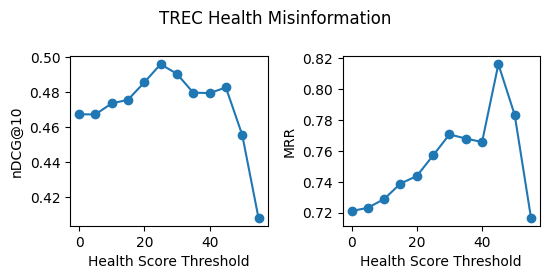

In [20]:
scale = 0.7
fig, axes = plt.subplots(1, 2, figsize=(8 * scale, 4 * scale))
for idx, metric in enumerate(("nDCG@10", "MRR")):
    ax = axes[idx]
    ax.plot(results.index, results.loc[:, metric], marker="o")
    ax.set_ylabel(metric)
    ax.set_xlabel("Health Score Threshold")
fig.suptitle("TREC Health Misinformation")
fig.tight_layout()

# DirichletLM

In [33]:
dataset = "clueweb12-trec-misinfo-2019-20240214-training"
topics = pt.get_dataset("irds:clueweb12/b13/trec-misinfo-2019").get_topics(variant="title")
qrels = pt.get_dataset("irds:clueweb12/b13/trec-misinfo-2019").get_qrels(variant="relevance")
document_health_classification = tira.pt.transform_documents("ir-benchmarks/fschlatt/document-health-classification", dataset)
bm25 = tira.pt.from_submission("ir-benchmarks/tira-ir-starter/DirichletLM Re-Rank (tira-ir-starter-pyterrier)", dataset)
bm25_health = bm25 % 1000 >> document_health_classification

There are multiple qrel fields available: ['relevance', 'effectiveness', 'redibility']. Defaulting to "relevance", but to use a different one, supply variant


In [34]:
bm25_ranking = bm25_health(topics)
bm25_ranking

,qid,query,q0,rank,score,system,docno,tira_task,tira_dataset,tira_first_stage_run_id,mean_health_score,median_health_score,mean_medical_score,median_medical_score
0,1,cranberries urinary tract infections,Q0,1,16.953256,pyterrier.default_pipelines.wmodel_text_scorer,clueweb12-1514wb-75-03723,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-14-56-54,60.0634,0.1428,85.1522,8.0731
1,1,cranberries urinary tract infections,Q0,2,16.794832,pyterrier.default_pipelines.wmodel_text_scorer,clueweb12-1712wb-84-02961,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-14-56-54,108.1876,67.2081,114.9722,74.7917
2,1,cranberries urinary tract infections,Q0,3,16.564677,pyterrier.default_pipelines.wmodel_text_scorer,clueweb12-1514wb-50-05021,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-14-56-54,97.8244,52.5293,106.5242,71.3221
3,1,cranberries urinary tract infections,Q0,4,16.520074,pyterrier.default_pipelines.wmodel_text_scorer,clueweb12-1515wb-33-25929,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-14-56-54,101.3218,57.5093,119.0994,79.4458
4,1,cranberries urinary tract infections,Q0,5,16.486682,pyterrier.default_pipelines.wmodel_text_scorer,clueweb12-1304wb-88-12518,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-14-56-54,108.0479,66.5542,113.0515,74.5736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50994,51,dehumidifiers asthma,Q0,995,1.385201,pyterrier.default_pipelines.wmodel_text_scorer,clueweb12-1007wb-24-17071,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-14-56-54,52.0621,19.0757,64.5174,26.3843
50995,51,dehumidifiers asthma,Q0,996,1.316988,pyterrier.default_pipelines.wmodel_text_scorer,clueweb12-1411wb-44-17605,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-14-56-54,62.2313,36.9000,66.3142,49.2285
50996,51,dehumidifiers asthma,Q0,997,1.307131,pyterrier.default_pipelines.wmodel_text_scorer,clueweb12-0507wb-68-20656,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-14-56-54,62.0919,34.9866,86.9873,54.7226
50997,51,dehumidifiers asthma,Q0,998,1.259419,pyterrier.default_pipelines.wmodel_text_scorer,clueweb12-1614wb-02-17964,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-14-56-54,93.1677,48.3995,94.6239,65.8722


In [35]:
rankings = []
thresholds = list(range(0, 60, 5))
for threshold in thresholds:
    rankings.append(bm25_ranking.loc[bm25_ranking["median_health_score"] >= threshold])

In [36]:
results = pt.Experiment(
    rankings,
    topics,
    qrels.rename({"label": "relevance"}, axis=1),
    ['ndcg_cut.10', 'recip_rank'],
    names=thresholds,
).rename({"name": "Health Score Threshold", "ndcg_cut.10": "nDCG@10", "recip_rank": "MRR"}, axis=1)
results = results.set_index("Health Score Threshold")
results

,nDCG@10,MRR
Health Score Threshold,,
0,0.395890,0.639551
5,0.392827,0.650913
10,0.396698,0.659913
15,0.400936,0.656579
20,0.408964,0.660270
25,0.420976,0.667413
30,0.413129,0.674285
35,0.395621,0.684285
40,0.396495,0.705022


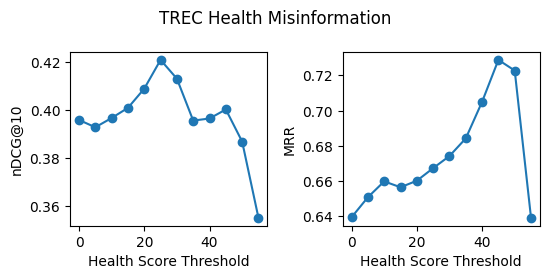

In [37]:
scale = 0.7
fig, axes = plt.subplots(1, 2, figsize=(8 * scale, 4 * scale))
for idx, metric in enumerate(("nDCG@10", "MRR")):
    ax = axes[idx]
    ax.plot(results.index, results.loc[:, metric], marker="o")
    ax.set_ylabel(metric)
    ax.set_xlabel("Health Score Threshold")
fig.suptitle("TREC Health Misinformation")
fig.tight_layout()

# MonoT5

In [44]:
dataset = "clueweb12-trec-misinfo-2019-20240214-training"
topics = pt.get_dataset("irds:clueweb12/b13/trec-misinfo-2019").get_topics(variant="title")
qrels = pt.get_dataset("irds:clueweb12/b13/trec-misinfo-2019").get_qrels(variant="relevance")
document_health_classification = tira.pt.transform_documents("ir-benchmarks/fschlatt/document-health-classification", dataset)
bm25 = tira.pt.from_submission("ir-benchmarks/tira-ir-starter/MonoT5 Base (tira-ir-starter-gygaggle)", dataset)
bm25_health = bm25 % 1000 >> document_health_classification

There are multiple qrel fields available: ['relevance', 'effectiveness', 'redibility']. Defaulting to "relevance", but to use a different one, supply variant


Download: 964kiB [00:00, 8.07MiB/s]


Download finished. Extract...
Extraction finished:  /root/.tira/extracted_runs/ir-benchmarks/clueweb12-trec-misinfo-2019-20240214-training/tira-ir-starter


In [45]:
bm25_ranking = bm25_health(topics)
bm25_ranking

,qid,query,q0,rank,score,system,docno,tira_task,tira_dataset,tira_first_stage_run_id,mean_health_score,median_health_score,mean_medical_score,median_medical_score
0,1,cranberries urinary tract infections,0,1,-0.011960,castorini/monot5-base-msmarco-10k,clueweb12-0612wb-48-06128,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-14-55-57,52.5139,12.2976,84.1604,44.9997
1,1,cranberries urinary tract infections,0,2,-0.012179,castorini/monot5-base-msmarco-10k,clueweb12-1100wb-42-24270,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-14-55-57,73.6753,28.6258,123.6957,60.0157
2,1,cranberries urinary tract infections,0,3,-0.012684,castorini/monot5-base-msmarco-10k,clueweb12-1309wb-66-04887,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-14-55-57,85.1328,43.6221,133.2357,87.1570
3,1,cranberries urinary tract infections,0,4,-0.012884,castorini/monot5-base-msmarco-10k,clueweb12-0908wb-85-24723,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-14-55-57,65.9521,30.0989,86.9107,52.9474
4,1,cranberries urinary tract infections,0,5,-0.014070,castorini/monot5-base-msmarco-10k,clueweb12-1207wb-55-13945,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-14-55-57,78.8672,42.2202,148.7198,99.2418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50994,51,dehumidifiers asthma,0,995,-11.716431,castorini/monot5-base-msmarco-10k,clueweb12-1516wb-85-16736,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-14-55-57,61.8350,38.3390,78.2221,51.9701
50995,51,dehumidifiers asthma,0,996,-11.828877,castorini/monot5-base-msmarco-10k,clueweb12-0300wb-97-10173,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-14-55-57,48.7505,14.5529,80.8725,45.4343
50996,51,dehumidifiers asthma,0,997,-11.857443,castorini/monot5-base-msmarco-10k,clueweb12-1703wb-89-09044,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-14-55-57,54.0652,18.8561,63.2402,26.7763
50997,51,dehumidifiers asthma,0,998,-11.907468,castorini/monot5-base-msmarco-10k,clueweb12-0210wb-53-21439,ir-benchmarks,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-14-55-57,54.2535,15.9042,73.5243,29.0075


In [46]:
rankings = []
thresholds = list(range(0, 60, 5))
for threshold in thresholds:
    rankings.append(bm25_ranking.loc[bm25_ranking["median_health_score"] >= threshold])

In [47]:
results = pt.Experiment(
    rankings,
    topics,
    qrels.rename({"label": "relevance"}, axis=1),
    ['ndcg_cut.10', 'recip_rank'],
    names=thresholds,
).rename({"name": "Health Score Threshold", "ndcg_cut.10": "nDCG@10", "recip_rank": "MRR"}, axis=1)
results = results.set_index("Health Score Threshold")
results

,nDCG@10,MRR
Health Score Threshold,,
0,0.486835,0.782772
5,0.490378,0.784442
10,0.492162,0.798803
15,0.497177,0.802237
20,0.497976,0.802262
25,0.485814,0.796602
30,0.482651,0.810317
35,0.470366,0.772951
40,0.444610,0.751048


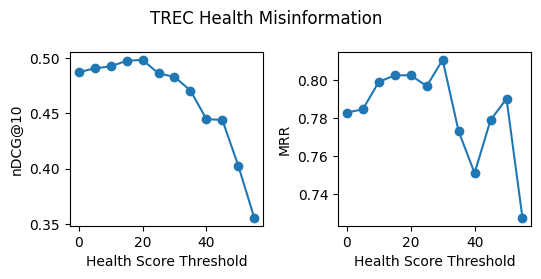

In [48]:
scale = 0.7
fig, axes = plt.subplots(1, 2, figsize=(8 * scale, 4 * scale))
for idx, metric in enumerate(("nDCG@10", "MRR")):
    ax = axes[idx]
    ax.plot(results.index, results.loc[:, metric], marker="o")
    ax.set_ylabel(metric)
    ax.set_xlabel("Health Score Threshold")
fig.suptitle("TREC Health Misinformation")
fig.tight_layout()

# Splade

In [39]:
dataset = "clueweb12-trec-misinfo-2019-20240214-training"
topics = pt.get_dataset("irds:clueweb12/b13/trec-misinfo-2019").get_topics(variant="title")
qrels = pt.get_dataset("irds:clueweb12/b13/trec-misinfo-2019").get_qrels(variant="relevance")
document_health_classification = tira.pt.transform_documents("ir-benchmarks/fschlatt/document-health-classification", dataset)
bm25 = tira.pt.from_submission("workshop-on-open-web-search/naverlabseurope/Splade (re-ranker)", dataset)
bm25_health = bm25 % 1000 >> document_health_classification

There are multiple qrel fields available: ['relevance', 'effectiveness', 'redibility']. Defaulting to "relevance", but to use a different one, supply variant


In [40]:
bm25_ranking = bm25_health(topics)
bm25_ranking

,qid,query,q0,rank,score,system,docno,tira_task,tira_dataset,tira_first_stage_run_id,mean_health_score,median_health_score,mean_medical_score,median_medical_score
0,1,cranberries urinary tract infections,0,1,24.694701,my-system-name,clueweb12-1309wb-66-04887,workshop-on-open-web-search,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-15-03-57,85.1328,43.6221,133.2357,87.1570
1,1,cranberries urinary tract infections,0,2,23.784552,my-system-name,clueweb12-1100wb-42-24270,workshop-on-open-web-search,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-15-03-57,73.6753,28.6258,123.6957,60.0157
2,1,cranberries urinary tract infections,0,3,23.752923,my-system-name,clueweb12-0109wb-83-09551,workshop-on-open-web-search,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-15-03-57,107.0973,55.9035,124.5779,84.6786
3,1,cranberries urinary tract infections,0,4,23.736344,my-system-name,clueweb12-1809wb-97-14794,workshop-on-open-web-search,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-15-03-57,72.5543,40.2659,98.6875,59.9471
4,1,cranberries urinary tract infections,0,5,23.512882,my-system-name,clueweb12-0104wb-93-33234,workshop-on-open-web-search,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-15-03-57,125.4036,70.0141,124.0446,74.0077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50994,51,dehumidifiers asthma,0,995,0.041757,my-system-name,clueweb12-1703wb-61-06943,workshop-on-open-web-search,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-15-03-57,49.7276,28.1963,67.4862,40.9963
50995,51,dehumidifiers asthma,0,996,0.033382,my-system-name,clueweb12-0101wb-99-20260,workshop-on-open-web-search,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-15-03-57,62.8626,36.7756,81.7350,51.5897
50996,51,dehumidifiers asthma,0,997,0.019441,my-system-name,clueweb12-0305wb-27-19517,workshop-on-open-web-search,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-15-03-57,55.2072,23.8824,60.7514,31.5140
50997,51,dehumidifiers asthma,0,998,0.008731,my-system-name,clueweb12-0300wb-97-10173,workshop-on-open-web-search,clueweb12-trec-misinfo-2019-20240214-training,2024-03-19-15-03-57,48.7505,14.5529,80.8725,45.4343


In [41]:
rankings = []
thresholds = list(range(0, 60, 5))
for threshold in thresholds:
    rankings.append(bm25_ranking.loc[bm25_ranking["median_health_score"] >= threshold])

In [42]:
results = pt.Experiment(
    rankings,
    topics,
    qrels.rename({"label": "relevance"}, axis=1),
    ['ndcg_cut.10', 'recip_rank'],
    names=thresholds,
).rename({"name": "Health Score Threshold", "ndcg_cut.10": "nDCG@10", "recip_rank": "MRR"}, axis=1)
results = results.set_index("Health Score Threshold")
results

,nDCG@10,MRR
Health Score Threshold,,
0,0.452698,0.808510
5,0.455017,0.808534
10,0.455339,0.809381
15,0.456980,0.810169
20,0.454947,0.811246
25,0.443900,0.812434
30,0.439326,0.812818
35,0.439902,0.804937
40,0.413496,0.726326


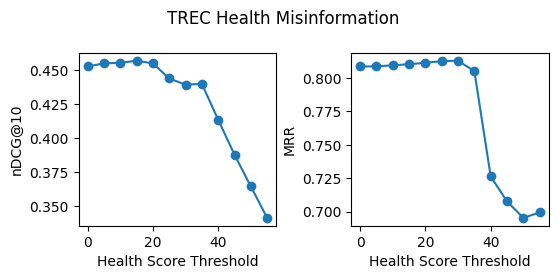

In [43]:
scale = 0.7
fig, axes = plt.subplots(1, 2, figsize=(8 * scale, 4 * scale))
for idx, metric in enumerate(("nDCG@10", "MRR")):
    ax = axes[idx]
    ax.plot(results.index, results.loc[:, metric], marker="o")
    ax.set_ylabel(metric)
    ax.set_xlabel("Health Score Threshold")
fig.suptitle("TREC Health Misinformation")
fig.tight_layout()